In [29]:
import torch
import sys

sys.path.append("../")
from RNN_Class import *
import matplotlib.pyplot as plt

In [30]:
N, SeqN, HN = 100, 100, 100
RecordN = 2000

### Load input data

In [24]:
# load input data
data_path = f"../data/Ns{N}_SeqN{SeqN}/"
data_name = "Ns{}_SeqN{}_1".format(N, SeqN)
data = torch.load(data_path + data_name + ".pth.tar")
X_mini = data["X_mini"][:, :-1, :]
Target_mini = data["Target_mini"][:, 1:, :]

print("X_mini shape", X_mini.shape)
print("Target_mini shape:", Target_mini.shape)

X_mini shape torch.Size([1, 99, 100])
Target_mini shape: torch.Size([1, 99, 100])


Env 1: X_mini


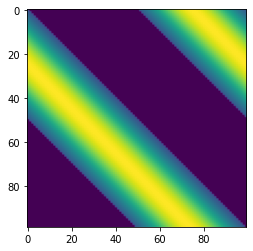

Env 1: Target_mini


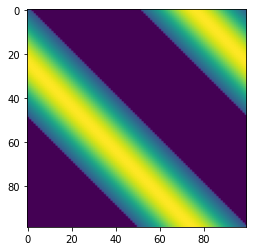

In [26]:
print("Env 1: X_mini")
plt.imshow(X_mini[0, :, :])
plt.show()

print("Env 1: Target_mini")
plt.imshow(Target_mini[0, :, :])
plt.show()

In [27]:
# load input data
data_path = f"../data/Ns{N}_SeqN{SeqN}/"
data_name = "Ns{}_SeqN{}_2".format(N, SeqN)
data = torch.load(data_path + data_name + ".pth.tar")
X_mini = data["X_mini"][:, :-1, :]
Target_mini = data["Target_mini"][:, 1:, :]

print("X_mini shape", X_mini.shape)
print("Target_mini shape:", Target_mini.shape)

X_mini shape torch.Size([1, 99, 100])
Target_mini shape: torch.Size([1, 99, 100])


Env 2: X_mini


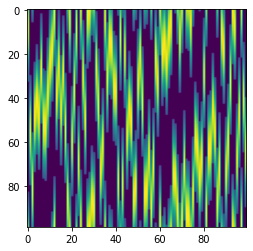

Env 2: Target_mini


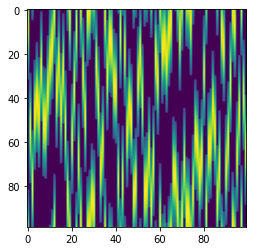

In [28]:
print("Env 2: X_mini")
plt.imshow(X_mini[0, :, :])
plt.show()

print("Env 2: Target_mini")
plt.imshow(Target_mini[0, :, :])
plt.show()

In [5]:
Path = "Elman_SGD/Remap_predloss/"

model_name = "Ns{}_SeqN{}_predloss_full".format(N, SeqN)
model = ElmanRNN_tp1(N, HN, N)
model.act = nn.Sigmoid()
model_remap = ElmanRNN_tp1(N, HN, N)
model_remap.act = nn.Sigmoid()
net = torch.load(Path + model_name + ".pth.tar", map_location="cuda:0")

model.load_state_dict(net["state_dict"])

output_previous, _ = model(X_mini, torch.zeros((1, 1, HN)))

FileNotFoundError: [Errno 2] No such file or directory: 'Elman_SGD/Remap_predloss/Ns200_SeqN100_predloss_full.pth.tar'